# SPAM DETECTION SYSTEM

This project aims to build a spam detection system using Natural Language Processing (NLP) techniques in order to classify emails as spam or not spam based on the content of the email.
The steps involved in this project are:
1. Train a classifier to identify spam emails.
2. Find out the principal topics of the spam emails.
3. Compute the semantic similarity between the spam emails, to verify the etheroegeneity of the spam emails.
4. Extract from non-spam emails the Organisations mentioned in the emails.

In [1]:
import pandas as pd
import numpy as np
import models as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi=False

2024-07-15 10:48:39.081092: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 10:48:39.082857: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 10:48:39.108367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 10:48:39.108400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 10:48:39.109097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

The dataset is available in data, and it is called `spam_dataset.csv`. It contains the following columns:

In [2]:
spam_df = pd.read_csv('../data/spam_dataset.csv', index_col=0)
spam_df.head(5)
print('------------------')
spam_df.shape
print('------------------')
spam_df.isnull().sum()
print('------------------')
spam_df['text'][605]
print('------------------')
spam_df.value_counts('label')

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\nthis deal is to ...,0


------------------


(5171, 3)

------------------


label        0
text         0
label_num    0
dtype: int64

------------------


"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

------------------


label
ham     3672
spam    1499
Name: count, dtype: int64

* *Label* column is the target variable and it is binary categorical. <br>
* *Text* column is the email content. <br>
* *Label_num* column is the target variable encoded as 0 for ham and 1 for spam. <br>

We can see the distribution of the target variable below.

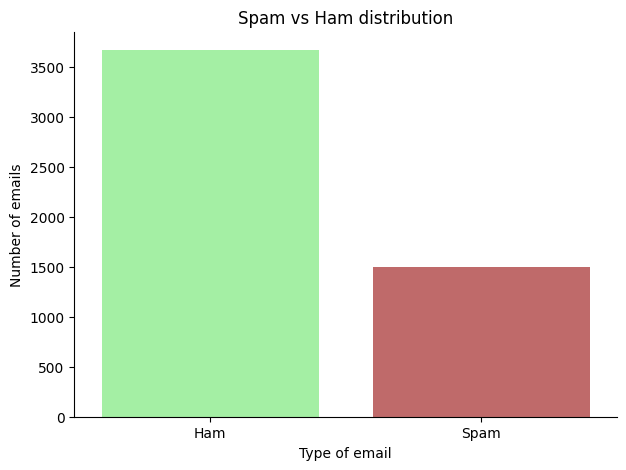

In [3]:
import plots as pl
pl.plot_spam_vs_ham(spam_df.value_counts('label'))

## Preprocessing
Let reset the dataframe indexes, and import the necessary libraries for removing the stopwords, punctuation, and lemmatizing the text.<br>
As in [toxic comments filter](https://github.com/EnricoMiche1210760/toxic_comments_filter) project, we will use the `nltk` library to remove the stopwords and punctuation, and to lemmatize the text, while we use spacy to extract the organisations from the non-spam emails and for word tokenization.

In [3]:
spam_df.reset_index(drop=True, inplace=True)
spam_df.head(3)

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0


In [4]:
import nltk
import spacy
import os

try:
    nlp = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
try:
    eng_stopwords = nltk.corpus.stopwords.words('english')
except:
    nltk.download('stopwords')
    eng_stopwords = nltk.corpus.stopwords.words('english')
try:
    _ = nltk.tokenize.word_tokenize('test')
except:
    nltk.download('punkt')


In [5]:
np.argmax([len(spam_df['text'][i]) for i in range(spam_df.shape[0])])
emails = spam_df['text'].values


949

In order to correctly preprocess the text, the following steps are performed:
1. Remove the stopwords and punctuation.
2. Lemmatize the text.
3. Tokenize the text.

The first two steps are performed in *preprocess_text_and_store* function, which preprocesses the text and stores the result into the desired file.

In [8]:
from preprocess import preprocess_text_and_store
preprocessed_text= preprocess_text_and_store(emails, doc_store="preprocessed_spam_df.csv", store=True)

Before computing the third step, we split the dataset into training, validation and test set. Since the dataset is quite small, we will use 65% of the data for training, 15% for validation and 20% for testing.
The dataset is imbalanced, but we will not balance it, since the imbalance is not too severe.

In [9]:
from preprocess import train_test_val_split
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=spam_df['label_num'], test_size=0.2, val_size=0.15)

X_train[0:3]
y_train[0:3]

['dobmeos hgh energy level gone stukm introducing doctor formulated hgh human growth hormone also called hgh referred medical science master hormone plentiful young near age twenty one bodies begin produce less time forty nearly everyone deficient hgh eighty production normally diminished least advantages hgh increased muscle strength loss body fat increased bone density lower blood pressure quickens wound healing reduces cellulite improved vision wrinkle disappearance increased skin thickness texture increased energy levels improved sleep emotional stability improved memory mental alertness increased sexual potency resistance common illness strengthened heart muscle controlled cholesterol controlled mood swings new hair growth color restore read website unsubscribe',
 'nan',
 'enron actuals dec dec teco tap enron hpl gas daily lsp hpl katy enron']

array([1, 1, 0])

We can proceed with the tokenization of the text. We use 'Tokenizer' class from keras to tokenize the text, setting the maximum number of words to 1500; then we set the maximum length of the sequences by finding the maximum length of the sequences in the training set. We finally pad the sequences to have the same length.
The choice of using this strategy instead of computing the tf-idf matrix is due to the fact that the want to use the word embeddings to represent the text, and the word embeddings are learned during the training of the model.<br>
This strategy helps to import a pre-trained model, **lstm_cnn_model.keras**, which is a model that combines a Convolutional Neural Network (CNN) and a Long Short-Term Memory (LSTM), and it has been trained in the [toxic comments filter](https://github.com/EnricoMiche1210760/toxic_comments_filter).

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(X_train)

tokenizer.word_counts

OrderedDict([('dobmeos', 1),
             ('hgh', 10),
             ('energy', 498),
             ('level', 63),
             ('gone', 23),
             ('stukm', 1),
             ('introducing', 8),
             ('doctor', 47),
             ('formulated', 4),
             ('human', 18),
             ('growth', 77),
             ('hormone', 7),
             ('also', 484),
             ('called', 112),
             ('referred', 5),
             ('medical', 53),
             ('science', 8),
             ('master', 25),
             ('plentiful', 1),
             ('young', 161),
             ('near', 46),
             ('age', 48),
             ('twenty', 15),
             ('one', 576),
             ('bodies', 5),
             ('begin', 67),
             ('produce', 12),
             ('less', 225),
             ('time', 628),
             ('forty', 8),
             ('nearly', 14),
             ('everyone', 95),
             ('deficient', 1),
             ('eighty', 3),
             ('produ

In [11]:
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_val_padded = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)

Vocabulary size:  35469


We set the padding type to 'pre' in order to keep the most important information at the end of the sequences. This strategy is useful since the spam emails are usually short and the spam content is at the end of the email.

In [12]:
maxlen = len(max(X_train_padded, key=len))
X_train_padded = pad_sequences(X_train_padded, padding='pre', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_padded, padding='pre', maxlen=maxlen)
X_val_padded = pad_sequences(X_val_padded, padding='pre', maxlen=maxlen)

In [13]:
X_train_padded[0:5]
X_train_padded.shape
y_train.shape

array([[   0,    0,    0, ...,  373,  469,  536],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    9,  516,    3],
       [   0,    0,    0, ..., 1379,  259,   31],
       [   0,    0,    0, ...,  352,  605,  178]], dtype=int32)

(3360, 1529)

(3360,)

We finally obtain a training set of shape (3360, 1529).

## Predicting spam emails

In order to predict the spam emails, we create two different models, both based on neural networks. <br>
The first model is based on the pre-trained model **lstm_cnn_model.keras**, which is imported and trained on the training set. The model was initially trained to recognize the toxicity of a comment according to 6 different categories. To adapt the model to the spam detection task, we added an *input layer* with the shape of the sequences, and an *output layer* with a **sigmoid activation function**, since the task is binary classification.<br>
The choice of using this model is due to the fact that the model has already learned the word embeddings, and it has been trained on a similar task, so it should be able to recognize the spam emails. Precisely because of this similarity, we thought it was the best time to test reinforced learning.<br>
<br>
The second model is a **GRU model**, which is a simpler model than the first one, but it is still able to recognize the spam emails. The model is composed of an embedding layer, a GRU layer, and a dense layer with a sigmoid activation function. 
We pick the GRU model as a comparison to the first model, to see if a simpler model can achieve similar results. Moreover GRU is faster to train than LSTM, so it is useful to test the model on a smaller dataset.

In [14]:
import tensorflow as tf
early_stopping = md.EarlyStopping(5)

In [15]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.backend import clear_session
from models import GRU_model, weighted_binary_crossentropy

The first model, requires to use a weighted binary crossentropy loss function. We already said that the dataset is imbalanced, but the imbalance is not severe.<br>
Defining the weights for the loss function is useful to give more importance to the minority class, in this case the spam emails. The weights are calculated as follows:
$$
w_{0} = \frac{N}{2 \cdot \text{count}_{0}}
$$
$$
w_{1} = \frac{N}{2 \cdot \text{count}_{1}}
$$
where $N$ is the number of labels, and $\text{count}$ is the number of occurrences of the label in the dataset. 

In [17]:
clear_session()
w0 = [(1/np.sum(y_train == 0)) * (len(y_train) /2)]
w1 = [(1/np.sum(y_train == 1)) * (len(y_train) /2)] 
w0, w1

([0.7055858882822343], [1.7160367722165475])

Then the loss function is defined as:

$$
\text{L}_{w} = -\text{E} \left[ w_{0} \cdot y \cdot \log(p) + w_{1} \cdot (1 - y) \cdot \log(1 - p) \right]
$$
<br>

where $y$ is the true label, $p$ is the predicted label, and $\text{E}$ is the expectation (see *models.py*).

In [18]:
reinforced_model = "reinforced_lstm.keras"
tf_to_do = True
if reinforced_model in os.listdir('../models'):
    lstm_cnn_model = load_model("../models/"+reinforced_model, custom_objects={'loss': weighted_binary_crossentropy(w0, w1)})
    tf_to_do = False
else:                       
    lstm_cnn_model_keras = "lstm_cnn_model.keras"
    custom_objects = {'loss': weighted_binary_crossentropy(w0, w1)}
    transfer_learning_model = load_model("../models/"+lstm_cnn_model_keras, custom_objects=custom_objects, )

In [19]:
if tf_to_do:
    transfer_learning_model.summary()

In [20]:
if tf_to_do:
    new_input = Input(shape=(maxlen,))
    transfer_learning_model.summary()
    output = transfer_learning_model.layers[0](new_input)
    for i in range(1, len(transfer_learning_model.layers)):
        output = transfer_learning_model.layers[i](output)
    output = Dense(1, activation='sigmoid', name='output')(output)
    lstm_cnn_model = Model(new_input, output)

In [21]:
lstm_cnn_model.compile(optimizer='adam', loss=weighted_binary_crossentropy(w0, w1), metrics=['accuracy'])
lstm_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1529)]            0         
                                                                 
 embedding (Embedding)       (None, 1529, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1529, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1529, 200)         200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1529, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, 1525, 64)          64064     
                                                             

In [22]:
if tf_to_do:
    lstm_cnn_model.fit(X_train_padded, 
        y_train, 
        epochs=10, 
        validation_data=(X_val_padded, y_val), 
        batch_size=32, 
        callbacks=[early_stopping])
    lstm_cnn_model.save("../models/reinforced_lstm.keras")

In [23]:
clear_session()

In [24]:
gru_model_name = "gru_model.keras"
if gru_model_name in os.listdir('../models'):
        gru_model = load_model("../models/"+gru_model_name)
        gru_model.summary()
        gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

else:
        gru_model = GRU_model(vocab_size=vocab_size, maxlen=maxlen, activation='sigmoid')
        gru_model.summary()
        gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        gru_model.fit(X_train_padded, 
                y_train, 
                epochs=10, 
                validation_data=(X_val_padded, y_val), 
                batch_size=32, 
                callbacks=[early_stopping])

        gru_model.save("../models/"+gru_model_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1529, 256)         9080064   
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9228417 (35.20 MB)
Trainable params: 9228417 (35.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
y_pred = gru_model.predict(X_test_padded)

33/33 [==============================] - 6s 183ms/step


In [26]:
y_pred_cnn_lstm = lstm_cnn_model.predict(X_test_padded)

33/33 [==============================] - 14s 418ms/step


GRU model report:
		precision    recall  f1-score   support
           0       0.97      0.98      0.98       742
           1       0.95      0.92      0.94       293
	-------------------------------------------------


LSTM (reinforced) model report:
		precision    recall  f1-score   support
           0       0.99      0.97      0.98       742
           1       0.93      0.97      0.95       293
	-------------------------------------------------


GRU Model Confusion Matrix


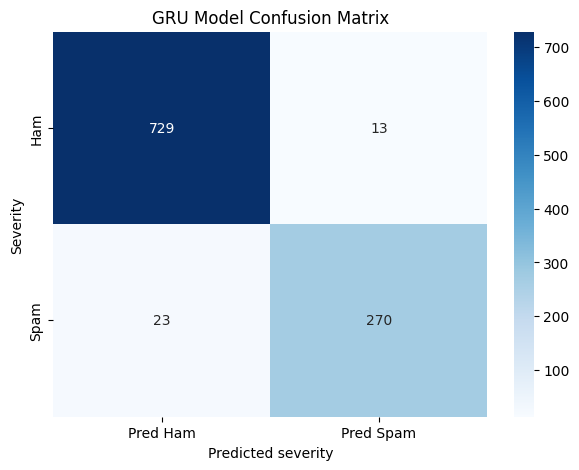

Reinforced LSTM Model Confusion Matrix


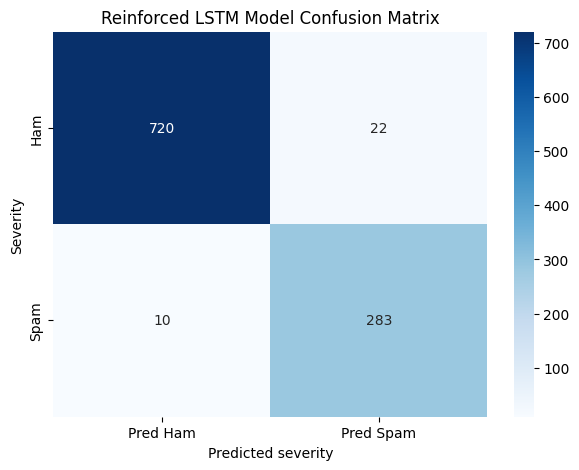

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from plots import print_confusion_matrix, print_table_from_classification_report

print_table_from_classification_report("GRU model report:", classification_report(y_test, np.round(y_pred)))
print_table_from_classification_report("LSTM (reinforced) model report:", classification_report(y_test, np.round(y_pred_cnn_lstm)))
print_confusion_matrix(y_test, np.round(y_pred), "GRU Model Confusion Matrix")
print_confusion_matrix(y_test, np.round(y_pred_cnn_lstm), "Reinforced LSTM Model Confusion Matrix")

In [28]:
y_pred_cnn_lstm = np.round(y_pred_cnn_lstm)

<Figure size 640x480 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

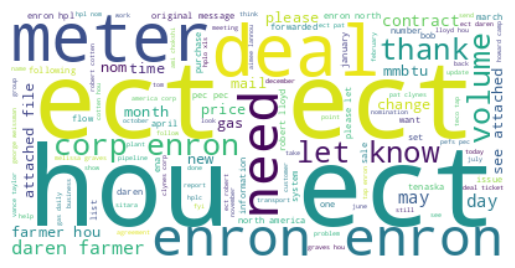

<Figure size 640x480 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

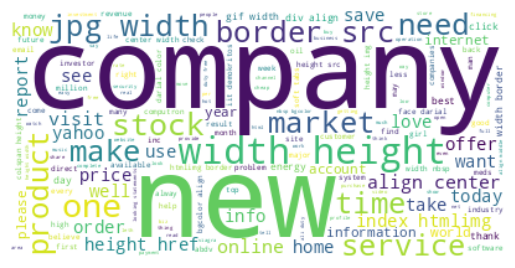

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ham_text = " ".join(X_test[idx] for idx in np.where(y_pred_cnn_lstm == 0)[0])
pl.show_wordcloud(ham_text, "Ham Wordcloud")

spam_text = " ".join(X_test[idx] for idx in np.where(y_pred_cnn_lstm == 1)[0])
pl.show_wordcloud(spam_text, "Spam Wordcloud")

## Clustering of spam emails

IDEA: per individuare il numero di topics, possiamo usare l'elbow method, che consiste nel calcolare la somma dei quadrati delle distanze tra i punti e i centroidi. Questo valore viene calcolato per un numero di cluster crescente, e si sceglie il numero di cluster in cui la somma delle distanze si stabilizza.


In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer

spam_text = preprocessed_text[spam_df[spam_df['label_num'] == 1].index[:]]
list_spam_text = [str(text) for text in spam_text] 
tfidf = TfidfVectorizer()

spam_tfidf = tfidf.fit_transform(list_spam_text)

In [138]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def compute_inertia_with_kmeans_pp(data):
    sse = {}

    for k in range(1, 11):
        kmeans = KMeans(init="k-means++", n_clusters=k)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), marker="o")
    plt.show()

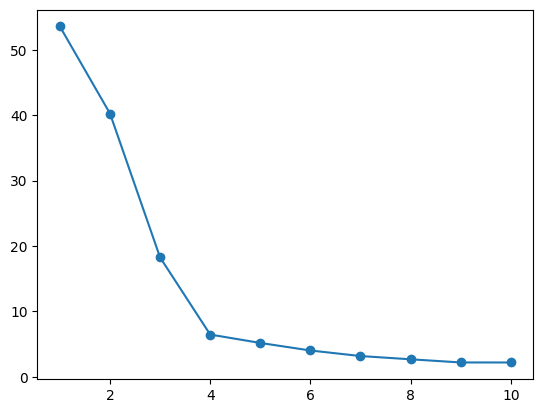

In [139]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=7)
X_3d = pca.fit_transform(spam_tfidf)

compute_inertia_with_kmeans_pp(X_3d)

In [141]:
from plots import plot_scatter_3D
%matplotlib inline
RANDOM_SEED = 0
n_clusters = 5
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=RANDOM_SEED)
kmeans.fit(X_3d)
test_cluster = kmeans.labels_
centers = kmeans.cluster_centers_
y_kmeans = kmeans.predict(X_3d)
L = {x : f"Cluster n. {x+1}" for x in range(n_clusters)}
dict_X = {'x' : X_3d[:,0], 'y' : X_3d[:,1], 'z' : X_3d[:,2]}

plot_scatter_3D(dict_X, L, y_kmeans, kmeans.cluster_centers_, point_size = 5)

KMeans(n_clusters=5, random_state=0)

In [142]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore

spam_text = [str(text).split() for text in spam_text]

dictionary = corpora.Dictionary(spam_text)

len(dictionary)

dictionary.filter_extremes(no_below=5, no_above=0.95)

len(dictionary)

corpus = [dictionary.doc2bow(text) for text in spam_text]


lda_model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=n_clusters,
                        random_state=100,
                        passes=10)


topics = lda_model.print_topics(num_words=10)
topics

36533

4114

[(0,
  '0.014*"http" + 0.011*"com" + 0.011*"get" + 0.006*"online" + 0.006*"new" + 0.006*"www" + 0.005*"time" + 0.005*"best" + 0.005*"one" + 0.005*"cialis"'),
 (1,
  '0.014*"pills" + 0.009*"money" + 0.009*"account" + 0.007*"please" + 0.005*"email" + 0.004*"com" + 0.004*"business" + 0.004*"bank" + 0.004*"million" + 0.004*"free"'),
 (2,
  '0.048*"font" + 0.040*"http" + 0.036*"height" + 0.031*"width" + 0.024*"size" + 0.023*"align" + 0.020*"border" + 0.019*"com" + 0.019*"www" + 0.018*"href"'),
 (3,
  '0.015*"company" + 0.011*"statements" + 0.008*"information" + 0.008*"may" + 0.007*"com" + 0.006*"report" + 0.006*"within" + 0.006*"stock" + 0.006*"securities" + 0.006*"investment"'),
 (4,
  '0.021*"nbsp" + 0.011*"windows" + 0.010*"price" + 0.010*"adobe" + 0.009*"email" + 0.009*"com" + 0.008*"software" + 0.007*"professional" + 0.007*"office" + 0.007*"new"')]

In [143]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, "lda.html")
pyLDAvis.display(lda_display)

Let verify if 4 topics are enough to cluster the spam emails, measuring the coherence of the topics, computing the coherence score of the topics, varying the number of topics from 2 to 10.

In [144]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=100, passes=10)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=spam_text, start=2, limit=10, step=1)
coherence_values


[0.5156019374930101,
 0.5554519204694772,
 0.49727965799204044,
 0.5579913483569705,
 0.4654698635235716,
 0.5731948030123165,
 0.4709017240952841,
 0.4857888170969149]

In [146]:
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(model_list[5], corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, "lda.html")
pyLDAvis.display(lda_display)

## Organisations mentioned in non-spam emails

In [147]:
ham_text = preprocessed_text[spam_df[spam_df['label_num'] == 0].index[:]]
list_ham_text = [str(text) for text in ham_text]

In [164]:
def find_organization_names(text):
    organizations_docs = {}
    for doc in text:
        organizations_docs[doc] = []
        nlp_doc = nlp(doc)
        for word in nlp_doc:
            if word.ent_type_ == 'ORG':
                organizations_docs[doc].append(word)
    return organizations_docs

organizations = find_organization_names(ham_text)
len(organizations)

3171

In [166]:
for i, doc in enumerate(organizations):
    counter = len(np.unique(organizations[doc]))
    if counter > 0:
        print('\n')
        print(f"In email: \"{doc}\"\nwe have found {counter} organizations, which are:")
        print(np.unique(organizations[doc]))   
        print('------------------')
    if i == 10:
        break




In email: "enron methanol meter follow note gave monday preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purposes"
we have found 3 organizations, which are:
[enron methanol meter]
------------------


In email: "neon retreat around wonderful time year neon leaders retreat time know time year extremely hectic tough think anything past holidays life past week december january like think minute calender handed beginning fall semester retreat scheduled weekend january youth ministers conference brad dustin connected week going change date following weekend january comes part need think think agree important get together time recharge batteries get far spring semester lot trouble difficult get away without kids etc brad came potential alternative get together weekend let know prefer first option would retreat similar done past several years year could heartland country inn www com ou